# Part 2 - Text Feature Extraction and Simple Classification

In Part 1, 28 emotions were reducted to 14 emotions and saved in 'merged_emotions.csv'. In this Part 2, the text will first undergo preprocessing using stopwords filtering, n-gram and lemmatization. Then, feature extraction techniques including BoW and TDIDF were experimented to create feature vectors which were then used in a classification model built with MLP. 

**This part contributes to coursework requirements, Task I - Tokenization, application of stopwords and n-grams transformation, text featurisation/transformation into numerical vectors.**

### Tokenization

In [7]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from numpy import genfromtxt
import matplotlib.pyplot as plt
from statistics import mean

In [8]:
df = pd.read_csv('merged_emotions.csv', encoding="utf-8", index_col=0)
data_words = df['text'].values.tolist()
data_labels = df['merged_labels']

First we will use gensim to perform preprocessing. Note that the parameter min_len is set to 1 to experiment the effect. When min_len=2, some information such as 'I', 'don't' which have some meaning will be lost.

In [ ]:
data_words = [gensim.utils.simple_preprocess(doc, min_len=1, deacc=True) for doc in data_words]
data_words[0:2]

Next 2-grams and 3-grams models are built.

In [ ]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Build the bigram and trigram models. The min_count and threshold parameters affect the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Try it out in one sample text
print('Bigram output:')
sent = [u'i', u'didn', u't', u'even', u'notice', u'that', u'one', u'i', u'noticed', u'the', u'bottom', u'right', u'one']
print(bigram_mod[sent])

trigram = gensim.models.Phrases(bigram_mod[data_words], min_count=5, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Try it out in one sample text
print('Trigram output:')
sent = [u'i', u'didn', u't', u'even', u'notice', u'that', u'one', u'i', u'noticed', u'the', u'bottom', u'right', u'one']
print(trigram_mod[sent])

Some utility functions for filtering stopwords, make n-Grams and perform lemmatization are defined below. NTLK stopwords and Spacy English model is adopted to perform lemmatization.

In [ ]:
import spacy
!python3 -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [12]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Apply these functions all together

In [ ]:
print('Sample text before filtering stopwords: ')
print(data_words[0:8])
print('----------------------------------------- ')

# Remove Stop Words
data_words_no_stopw = remove_stopwords(data_words)
print('Sample text after filtering stopwords: ')
print(data_words_no_stopw[0:8])
print('----------------------------------------- ')

# Do lemmatization keeping only noun, adj, vb, adv
print('Sample text after lemmatization: ')
data_words_no_stopw_with_lemma = lemmatization(data_words_no_stopw, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_words_no_stopw_with_lemma[0:8])
print('----------------------------------------- ')



We found that after stopwords filtering and lemmatization, many words in a text will be lost (e.g. from the first example text above). As a result, we will compare the results with and without stopwords filtering and lemmatization, as when there are too many words being removed from a text, information carrying emotion elements will be lost and affects the emotion classification accuracy.

In [ ]:
# Form Bigrams
data_words = make_bigrams(data_words)
print('Sample text with 2-gram and 3-gram: ')
print(data_words[0:3])

data_words_no_stopw_with_lemma = make_bigrams(data_words_no_stopw_with_lemma)
print('Sample text (with stopwords filtering and lemmatization) with 2-gram and 3-gram: ')
print(data_words_no_stopw_with_lemma[0:3])

Next we proceed to extract features as Bag of Words (BoW) and Term Frequency and Inverse Document Frequency (TFIDF) feature vectors.

There are numerous ways to extract features from text. Simple approaches can be BoW and TFIDF. Advanced techniques can be applying word embeddings and pre-trained transformers to tokenize and transform text into feature vectors. In this part, we will experiment simple methods, namely BoW and TFIDF. A simple NN will then be built for classifying the BoW and TFIDF feature vectors. In later parts, more advanced feature extraction approach will be experimented to compare the performance.

**This part contributes to Task III. Tokenization, application of stopwords and n-grams transformation, text featurisation/transformation into numerical vectors**

Define function to build feature vectors

In [ ]:
# Function to create BoW and TFIDF feature vectors
def CreateFeatureVectors(textlist):
    # Create Dictionary ({token: id})
    id2word = corpora.Dictionary(textlist)
    print(f'Length of dictionary {len(id2word)}')

    # Term Document Frequency (BoW features)
    feature_vec_bow_tuple = [id2word.doc2bow(text) for text in textlist]
    feature_vec_bow_dict= [dict(f) for f in feature_vec_bow_tuple]
    
    tfidf_mod = gensim.models.TfidfModel(feature_vec_bow_tuple)
    feature_vec_tfidf_tuple = [tfidf_mod[v] for v in feature_vec_bow_tuple]
    feature_vec_tfidf_dict = [dict(f) for f in feature_vec_tfidf_tuple]
    
    return feature_vec_bow_dict, feature_vec_tfidf_dict, len(id2word)

    
feature_vec_bow_no_stopws, feature_vec_tfidf_no_stopws, feature_vec_dim_no_stopws = CreateFeatureVectors(data_words_no_stopw_with_lemma)
feature_vec_bow, feature_vec_tfidf, feature_vec_dim  = CreateFeatureVectors(data_words)


Now we have total four sets of feature vectors (feature_vec_bow_no_stopws, feature_vec_tfidf_no_stopws, feature_vec_bow , feature_vec_tfidf) corresponding to BoW and TFIDF for texts with and without stopwords filtering and lemmatization. However, these feature vectors are in dictionary types. For feeding to a classifier model such as MLP, we need to convert them into full vector with length equal to the dictionary size shown above, and with each vector element position indicating the corresponding BoW frequency or TFIDF value of the corresponding word. This will create a huge matrix given the size of dataset. For example, for texts without stopwords and lemmatization, the input data matrix will be Sample Size x Dictionary Size = 54263 x 29393! It is impossible to fully load into memory, and thus we need to use generator function to convert each dictionary object to its corresponding feature vector for feeding into classification model input.

In [16]:
# A function to convert the feature dictionary to feature vector
def convert_feature_dict_to_vect(feature_dict, feature_dim):
    vec = [feature_dict.get(x) if feature_dict.get(x)!=None else 0 for x in range(0,feature_dim)]
    vec = torch.as_tensor(vec, dtype=torch.float32)
    return vec

# Define generator to generate each feature vector
def feature_vec_generator(feature_dict_list, feature_dim):
    for feature_dict in feature_dict_list:
        yield convert_feature_dict_to_vect(feature_dict, feature_dim)

Before creating dataloaders to generate feature vectors into classification model, we need to transform the target emotion labels and perform training, validation and testing set split.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data_labels)
Y_labels = le.transform(data_labels)

# feature_vec_bow_no_stopws, feature_vec_tfidf_no_stopws, feature_vec_bow , feature_vec_tfidf

# test_ratio = 0.2, val_ratio = 0.25
def CreateTrainTestValSet(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8964)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=8964)
    X_Dict = {'train': X_train, 'test': X_test, 'val': X_val}
    Y_Dict = {'train': y_train, 'test': y_test, 'val': y_val}
    
    return X_Dict, Y_Dict

X_bow_no_stopws, Y_bow_no_stopws = CreateTrainTestValSet(feature_vec_bow_no_stopws, Y_labels)
X_bow, Y_bow = CreateTrainTestValSet(feature_vec_bow, Y_labels)

X_tfidf_no_stopws, Y_tfidf_no_stopws = CreateTrainTestValSet(feature_vec_tfidf_no_stopws, Y_labels)
X_tfidf, Y_tfidf = CreateTrainTestValSet(feature_vec_tfidf, Y_labels)



Next we define the feature dataset and data loader maker to create dataloader objects for PyTorch training and evaluation.

In [19]:
class TextFeatureDataset(Dataset):
     def __init__(self, feature_dict_list=[], 
                          output_set=[], 
                          feature_dim=10):
         super(Dataset, self).__init__()
         self.feature_dict_list = feature_dict_list
         self.output_set = output_set
         self.feature_dim = feature_dim
        
     def __len__(self):
         return len(self.feature_dict_list)
        
     def __getitem__(self, index):
        if (index < len(self.feature_dict_list)):
            vec = self.feature_dict_list[index]
            label = self.output_set[index]
        else:
            vec = None
            label = None
            
        return vec, label

In [20]:
def DataLoaderMaker(X_Dict, Y_Dict, feature_vec_dim, batch_size=512):
    
    dataloader_dict = {}
    
    in_gen_bow = feature_vec_generator(X_Dict['train'], feature_vec_dim)
    out_labels = Y_Dict['train']
    
    X = [next(in_gen_bow) for i in range(0,len(out_labels))]
    Y = torch.as_tensor(np.array(out_labels), dtype=torch.float32)
       
    dataset = TextFeatureDataset(X, Y, feature_dim=X[0].shape[0])
    dataloader_dict['train'] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  shuffle=False, num_workers=0)
    
    
    in_gen_bow = feature_vec_generator(X_Dict['test'], feature_vec_dim)
    out_labels = Y_Dict['test']
    
    X = [next(in_gen_bow) for i in range(0,len(out_labels))]
    Y = torch.as_tensor(np.array(out_labels), dtype=torch.float32)
       
    dataset = TextFeatureDataset(X, Y, feature_dim=X[0].shape[0])
    dataloader_dict['test'] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  shuffle=False, num_workers=0)
    
    in_gen_bow = feature_vec_generator(X_Dict['val'], feature_vec_dim)
    out_labels = Y_Dict['val']
    
    X = [next(in_gen_bow) for i in range(0,len(out_labels))]
    Y = torch.as_tensor(np.array(out_labels), dtype=torch.float32)
       
    dataset = TextFeatureDataset(X, Y, feature_dim=X[0].shape[0])
    dataloader_dict['val'] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  shuffle=False, num_workers=0)
    

    return dataloader_dict

In [21]:
dataloader_dict_bow = DataLoaderMaker(X_bow, Y_bow, feature_vec_dim, batch_size=512)

In [22]:
dataloader_dict_tfidf = DataLoaderMaker(X_tfidf, Y_tfidf, feature_vec_dim, batch_size=512)

In [23]:
dataloader_dict_bow_no_stopws = DataLoaderMaker(X_bow_no_stopws, Y_bow_no_stopws, feature_vec_dim_no_stopws, batch_size=512)

In [24]:
dataloader_dict_tfidf_no_stopws = DataLoaderMaker(X_tfidf_no_stopws, Y_tfidf_no_stopws, feature_vec_dim_no_stopws, batch_size=512)

Next we create a simple 2-layer FC MLP as a classification model for classifying the emotion of a text. We also create the training and evaluation function for training the model using different datasets.

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

cuda:0


In [124]:
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

DATA_FOLDER = '/scratch/sk02039/'

torch.manual_seed(8964)    # reproducible experiments
                          # by fixing the seed you will remove randomness

class Net(torch.nn.Module):
    # initialise one hidden layer and one output layer
    def __init__(self, n_feature, n_hidden, n_output):
        # call pytorch superclass code to initialise nn
        super(Net, self).__init__()
        # hidden layer
        self.hidden = torch.nn.Linear(n_feature, n_hidden)  
        self.out = torch.nn.Linear(n_hidden, n_output)  # output layer

   
    def forward(self, x):
        # activation function for hidden layer is relu
        # data passes through hidden and relu
        x = F.relu(self.hidden(x))  
        x = F.relu(self.out(x))
        return x
    
def GetModel(n_feature, n_hidden, n_output):
    net = Net(n_feature=n_feature, n_hidden=n_hidden, n_output=n_output)  # define the network
    #optional printouts about network
    print("printing net")
    print(net)  # net architecture
    return net


def EvalNN(net, testlder, modelfilename):
    
    if (device.type=='cuda'):
         net.to(device)
        
    if modelfilename is not None:
        net.load_state_dict(torch.load(modelfilename))
        
    if (device.type=='cuda'):
         net.to(device)
        
    total_accuracy = []
    total_test_samples = 0
    
    y_target = []
    y_pred = []

    net.eval()
    net.train(False)
    
    with torch.no_grad():
        for data in testlder:
            inputs, labels = data
            if (device.type=='cuda'):
                inputs, labels = inputs.to(device), labels.to(device)
                
            predicted = net(inputs)
            acc = (predicted.argmax(dim=1) == labels).sum().item()
            total_accuracy.append(acc)
            total_test_samples +=  len(labels)
            
            y_target.extend(labels.data.cpu().numpy().astype(int))
            y_pred.extend(predicted.argmax(dim=1).data.cpu().numpy().astype(int))

            
    net.train(True)
    print(f'The average accuracy score is {sum(total_accuracy)/total_test_samples}')
    
           
    return sum(total_accuracy)/total_test_samples, y_target, y_pred


def TrainNN(net, trnlder, testlder, modelfilename, epoch):
    
    if (device.type=='cuda'):
        print('Load model to GPU')
        net.to(device)
        
    # What optimiser to use, e.g. SGD or Adam or RProp
    # optimizer = torch.optim.SGD(net.parameters(), lr=0.02) #lr = learning rate
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0002) #lr = learning rate

    loss_func = torch.nn.CrossEntropyLoss() #  Cross Entropy Loss

    loss_values = []
    eval_acc = []

    for t in range(epoch):
        
        epi_start_time = time.time()
        
        net.train(True)
        
        loss_values_per_batch = []
        for i, data in enumerate(trnlder):
            inputs, labels = data
            if (device.type=='cuda'):
                inputs, labels = inputs.to(device), labels.to(device)
            out = net(inputs)
            loss = loss_func(out, labels.long()) # compare output with grount truth label y
            optimizer.zero_grad()  # clear gradients for next train
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients
            loss_values_per_batch.append(loss.item()) # keep track of loss values for later plot
            #print(f'Completed {i} batch. Loss = {loss.item()}')

        loss_values.append(sum(loss_values_per_batch)/len(loss_values_per_batch))
        print(f'Completed epoch {t}. Loss = {loss_values[-1]}')
        
        # Eval
        acc, *_ = EvalNN(net, testlder, None)
        
        # Save the model if the eval accuracy is max so far
        if len(eval_acc)>0 and acc>max(eval_acc):
            fname = DATA_FOLDER + modelfilename
            torch.save(net.state_dict(), fname)  # save
        eval_acc.append(acc)
        
        epi_end_time = time.time()
        training_time = round(epi_end_time - epi_start_time)
        print(f"Episode {t} training and eval took {round(training_time,2)} seconds.")
        
    
    fname = DATA_FOLDER + modelfilename + '_trainloss'
    with open(fname, 'w') as fp:
        for item in loss_values:
            fp.write("%s\n" % item)
            
    fname = DATA_FOLDER + modelfilename + '_evalacc' 
    with open(fname, 'w') as fp:
        for item in eval_acc:
            fp.write("%s\n" % item)
            
    return loss_values, eval_acc
    
    
# function to generate confusion matrix display and classification report
def GenerateReports(y_true, y_pred, classlabels, figtitle):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                   xticks_rotation='vertical', 
                                                   display_labels=classlabels,
                                                   ax=ax)

    disp.ax_.set_title('Confusion Matrix: ' + figtitle)
    # disp.plot(ax=ax)
    disp.im_.colorbar.remove()

    print('Classificaton Report: ' + figtitle)
    print(classification_report(y_true, y_pred))
    
    
# function to plot training and evaluation results
def PlotTwinResults(ax, x_data, y_datas, x_label, y_labels, fig_title):
    ax.plot(range(0,len(x_data)),y_datas[0], color='r')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[0], color='r')
    ax2 = ax.twinx()
    ax2.plot(range(0,len(x_data)),y_datas[1], color='b')
    ax2.set_ylabel(y_labels[1], color='b')
    ax.set_title(fig_title)

Now we have four datasets listed below for evaluation. Let's train them one by one
- dataloader_dict_bow
- dataloader_dict_bow_no_stopws
- dataloader_dict_tfidf
- dataloader_dict_tfidf_no_stopws

In addition, the performance of the classifier will also be changed by network size (number of neurons) of the classification layer. Thus we examine the performance of the models by varying the network size using following number of neurons in the classification layer:

- 64
- 256
- 1024

In [125]:
lst_n_hidden = [64, 256, 1024]
n_output = len(le.classes_) # 14 emotions including neutral
epochs = 200

In [ ]:
loss_values_bow = []
eval_acc_bow = []
loss_values_tfidf = []
eval_acc_tfidf = []
loss_values_bow_no_stopws = []
eval_acc_bow_no_stopws = []
loss_values_tfidf_no_stopws = []
eval_acc_tfidf_no_stopws = []

for n_hidden in lst_n_hidden:
    n_feature = feature_vec_dim
    nn_model_bow = GetModel(n_feature, n_hidden, n_output)
    loss, evl= TrainNN(nn_model_bow, dataloader_dict_bow['train'], 
                        dataloader_dict_bow['val'], 
                        'nn_model_bow_'+str(n_hidden)+'.pkl', epochs)
    
    loss_values_bow.append(loss)
    eval_acc_bow.append(evl)

    
    n_feature = feature_vec_dim
    nn_model_tfidf = GetModel(n_feature, n_hidden, n_output)
    loss, evl = TrainNN(nn_model_tfidf, dataloader_dict_tfidf['train'], 
                        dataloader_dict_tfidf['val'], 
                        'nn_model_tfidf_'+str(n_hidden)+'.pkl', epochs)
    
    loss_values_tfidf.append(loss)
    eval_acc_tfidf.append(evl)

    
    n_feature = feature_vec_dim_no_stopws
    nn_model_bow_no_stopws = GetModel(n_feature, n_hidden, n_output)
    loss, evl = TrainNN(nn_model_bow_no_stopws, dataloader_dict_bow_no_stopws['train'], 
                        dataloader_dict_bow_no_stopws['val'], 
                        'nn_model_bow_no_stopws_'+str(n_hidden)+'.pkl', epochs)

    loss_values_bow_no_stopws.append(loss)
    eval_acc_bow_no_stopws.append(evl)
    
    
    n_feature = feature_vec_dim_no_stopws
    nn_model_tfidf_no_stopws = GetModel(n_feature, n_hidden, n_output)
    loss, evl = TrainNN(nn_model_tfidf_no_stopws, dataloader_dict_tfidf_no_stopws['train'], 
                                                                    dataloader_dict_tfidf_no_stopws['val'], 
                                                                    'nn_model_tfidf_no_stopws_'+str(n_hidden)+'.pkl', 
                                                                    epochs)
    loss_values_tfidf_no_stopws.append(loss)
    eval_acc_tfidf_no_stopws.append(evl)

### Plot the network size = 64 training and eval accuracy 

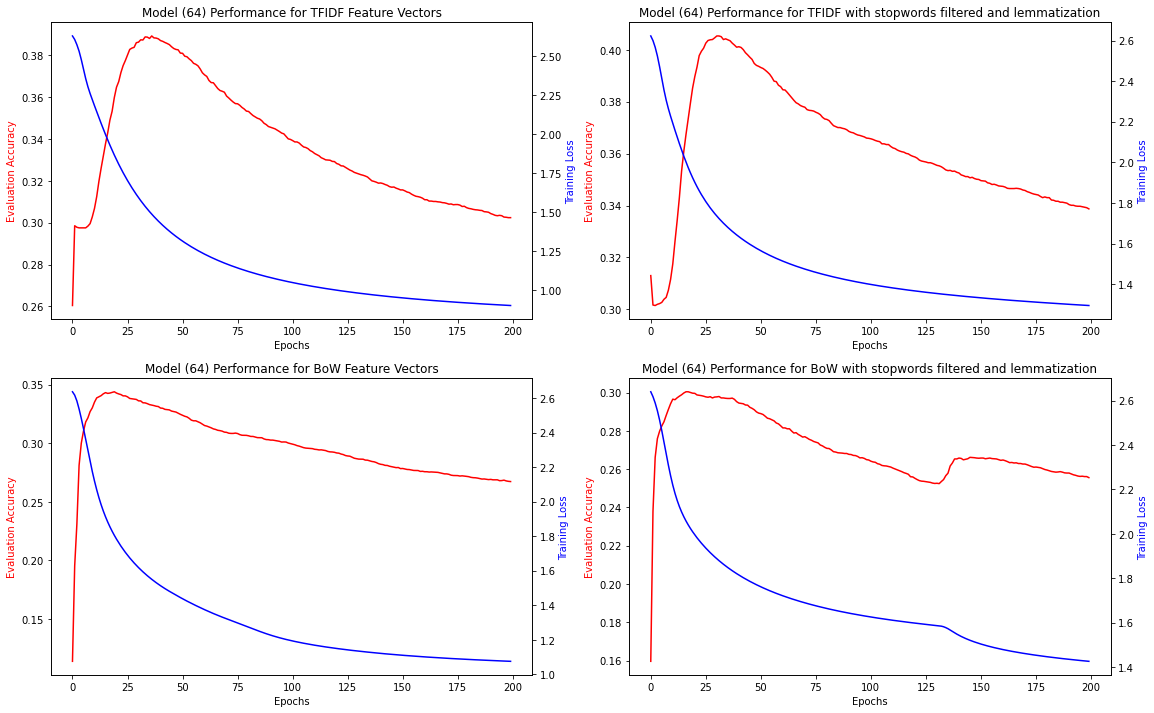

In [128]:
fig, ax = plt.subplots(2,2,figsize=(19,12))
k = 0

PlotTwinResults(ax[0,0], range(0,len(eval_acc_tfidf[k])), 
                [eval_acc_tfidf[k], loss_values_tfidf[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (64) Performance for TFIDF Feature Vectors')

PlotTwinResults(ax[0,1], range(0,len(eval_acc_tfidf_no_stopws[k])), 
                [eval_acc_tfidf_no_stopws[k], loss_values_tfidf_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (64) Performance for TFIDF with stopwords filtered and lemmatization')

PlotTwinResults(ax[1,0], range(0,len(eval_acc_bow[k])), 
                [eval_acc_bow[k], loss_values_bow[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (64) Performance for BoW Feature Vectors')

PlotTwinResults(ax[1,1], range(0,len(eval_acc_bow_no_stopws[k])), 
                [eval_acc_bow_no_stopws[k], loss_values_bow_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (64) Performance for BoW with stopwords filtered and lemmatization')

### Plot the network size = 256 training and eval accuracy 

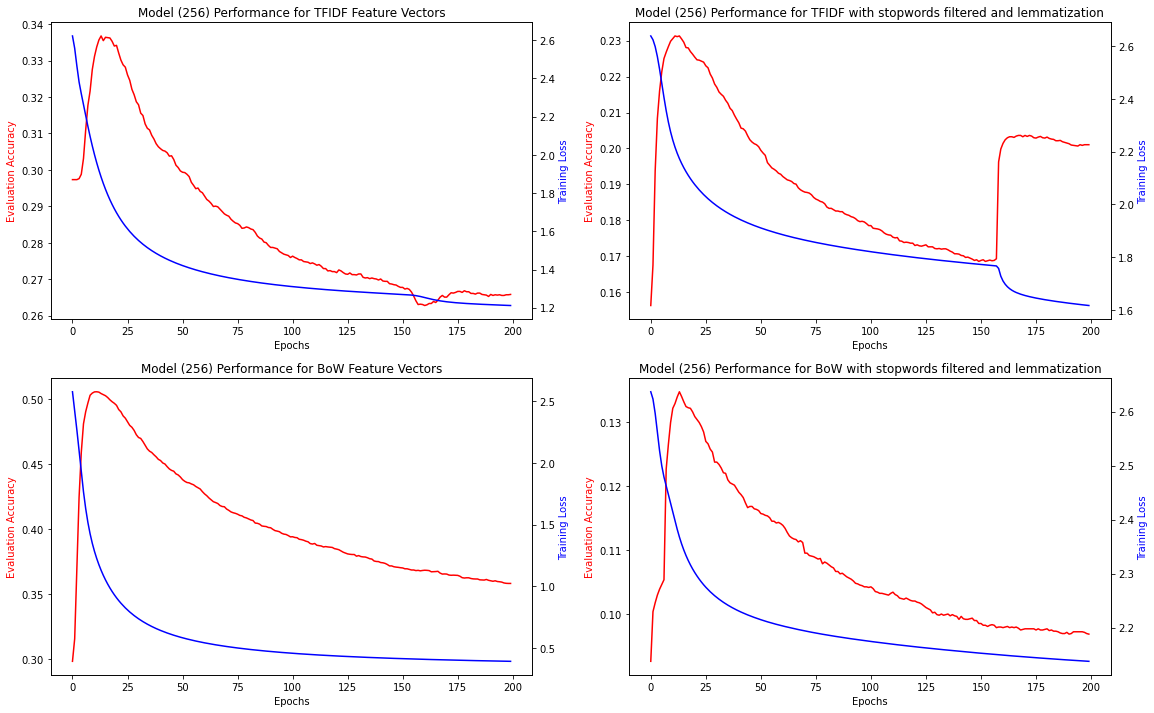

In [129]:
fig, ax = plt.subplots(2,2,figsize=(19,12))
k = 1

PlotTwinResults(ax[0,0], range(0,len(eval_acc_tfidf[k])), 
                [eval_acc_tfidf[k], loss_values_tfidf[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (256) Performance for TFIDF Feature Vectors')

PlotTwinResults(ax[0,1], range(0,len(eval_acc_tfidf_no_stopws[k])), 
                [eval_acc_tfidf_no_stopws[k], loss_values_tfidf_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (256) Performance for TFIDF with stopwords filtered and lemmatization')

PlotTwinResults(ax[1,0], range(0,len(eval_acc_bow[k])), 
                [eval_acc_bow[k], loss_values_bow[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (256) Performance for BoW Feature Vectors')

PlotTwinResults(ax[1,1], range(0,len(eval_acc_bow_no_stopws[k])), 
                [eval_acc_bow_no_stopws[k], loss_values_bow_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (256) Performance for BoW with stopwords filtered and lemmatization')

### Plot the network size = 1024 training and eval accuracy 

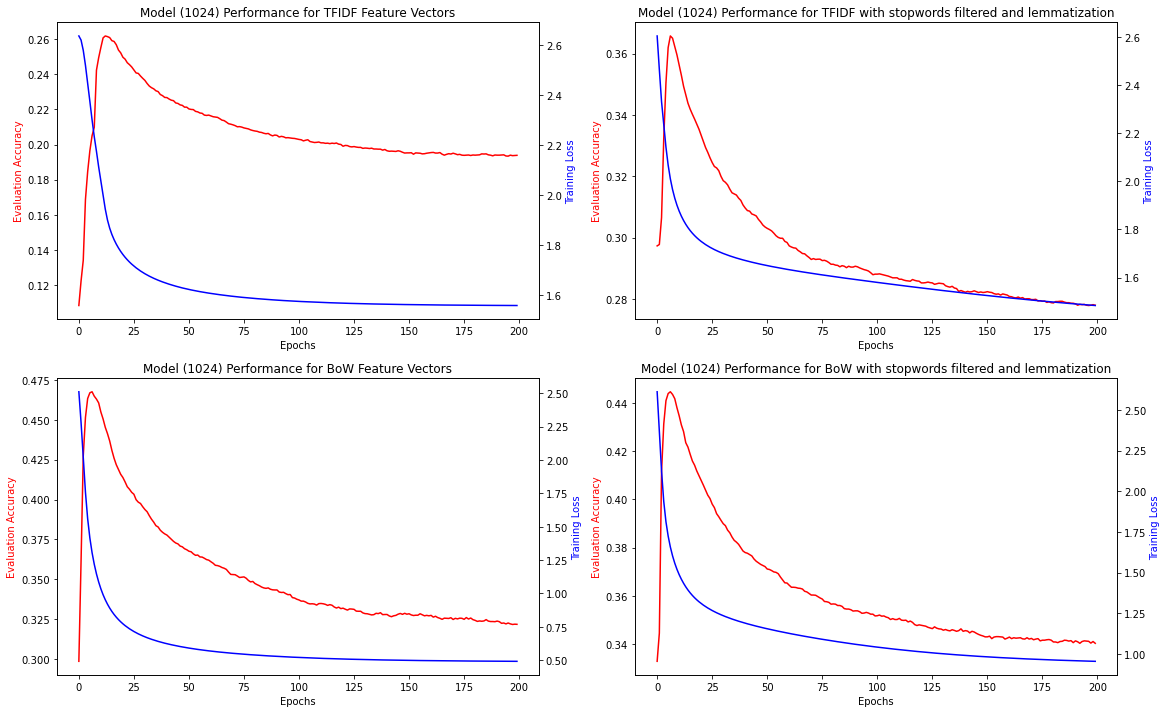

In [130]:
fig, ax = plt.subplots(2,2,figsize=(19,12))
k = 2

PlotTwinResults(ax[0,0], range(0,len(eval_acc_tfidf[k])), 
                [eval_acc_tfidf[k], loss_values_tfidf[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (1024) Performance for TFIDF Feature Vectors')

PlotTwinResults(ax[0,1], range(0,len(eval_acc_tfidf_no_stopws[k])), 
                [eval_acc_tfidf_no_stopws[k], loss_values_tfidf_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (1024) Performance for TFIDF with stopwords filtered and lemmatization')

PlotTwinResults(ax[1,0], range(0,len(eval_acc_bow[k])), 
                [eval_acc_bow[k], loss_values_bow[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (1024) Performance for BoW Feature Vectors')

PlotTwinResults(ax[1,1], range(0,len(eval_acc_bow_no_stopws[k])), 
                [eval_acc_bow_no_stopws[k], loss_values_bow_no_stopws[k]], 
                'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                'Model (1024) Performance for BoW with stopwords filtered and lemmatization')

### Confusion matrix and Classification Report for Network Size = 64

printing net
Net(
  (hidden): Linear(in_features=29393, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=14, bias=True)
)
The average accuracy score is 0.3472772505298074
Classificaton Report: (64) BoW Feature Vectors
                                                    precision    recall  f1-score   support

                                        admiration       0.36      0.72      0.48       724
                          amusement_joy_excitement       0.46      0.72      0.56       968
                           anger_annoyance_disgust       0.33      0.61      0.43       948
                                          approval       0.22      0.28      0.25       573
                            caring_desire_optimism       0.34      0.62      0.44       743
                               curiosity_confusion       0.25      0.49      0.33       723
disappointment_embarrassment_grief_remorse_sadness       0.37      0.61      0.46       752
                     

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The average accuracy score is 0.3866212107251451
Classificaton Report: (64) TFIDF Feature Vectors


/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.34      0.54      0.42       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.44      0.39      0.42       948
                                          approval       0.20      0.12      0.15       573
                            caring_desire_optimism       0.40      0.48      0.44       743
                               curiosity_confusion       0.28      0.23      0.25       723
disappointment_embarrassment_grief_remorse_sadness       0.00      0.00      0.00       752
                                       disapproval       0.20      0.12      0.15       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.35      0.73      0.47       724
                          amusement_joy_excitement       0.33      0.69      0.45       968
                           anger_annoyance_disgust       0.22      0.69      0.34       948
                                          approval       0.14      0.28      0.18       573
                            caring_desire_optimism       0.00      0.00      0.00       743
                               curiosity_confusion       0.00      0.00      0.00       723
disappointment_embarrassment_grief_remorse_sadness       0.28      0.59      0.38       752
                                       disapproval       0.14      0.08      0.10       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.65      0.79      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.36      0.51      0.42       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.43      0.37      0.40       948
                                          approval       0.00      0.00      0.00       573
                            caring_desire_optimism       0.00      0.00      0.00       743
                               curiosity_confusion       0.22      0.11      0.15       723
disappointment_embarrassment_grief_remorse_sadness       0.47      0.39      0.42       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.65      0.71      0.

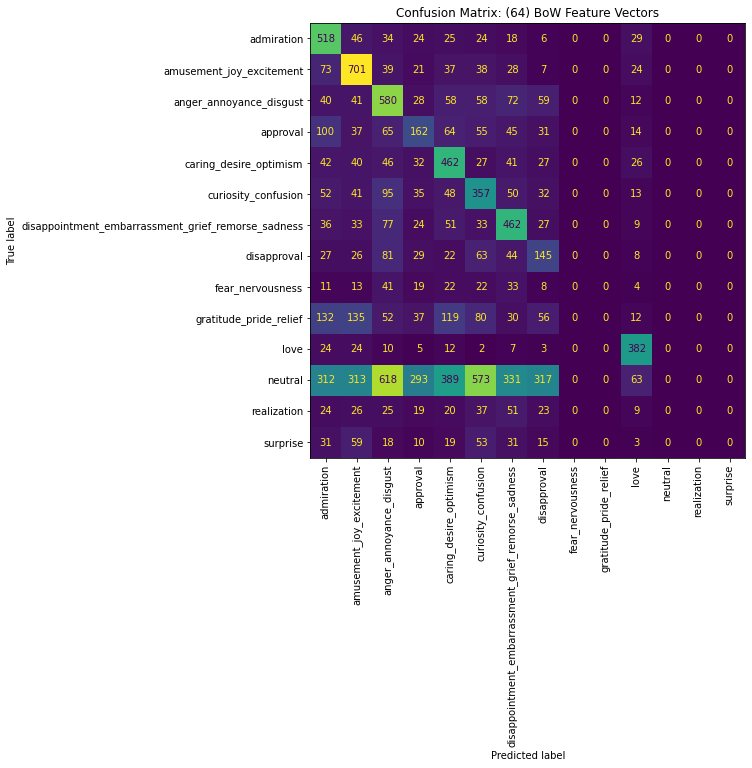

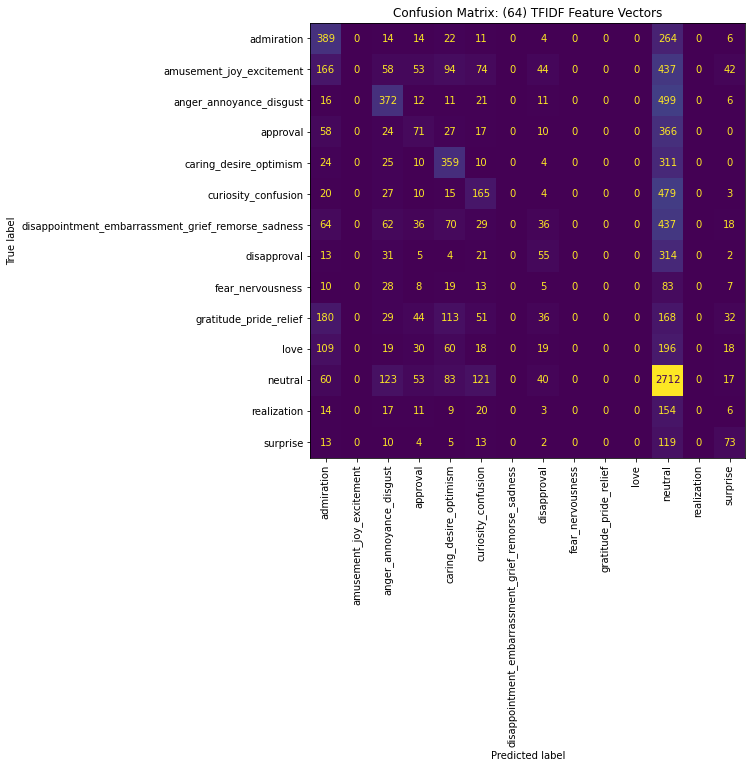

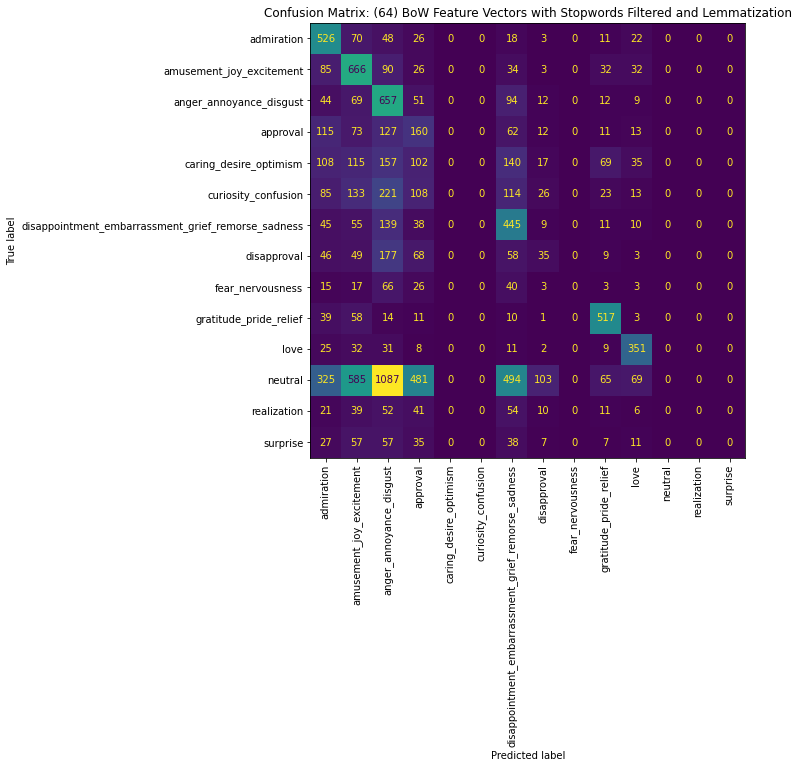

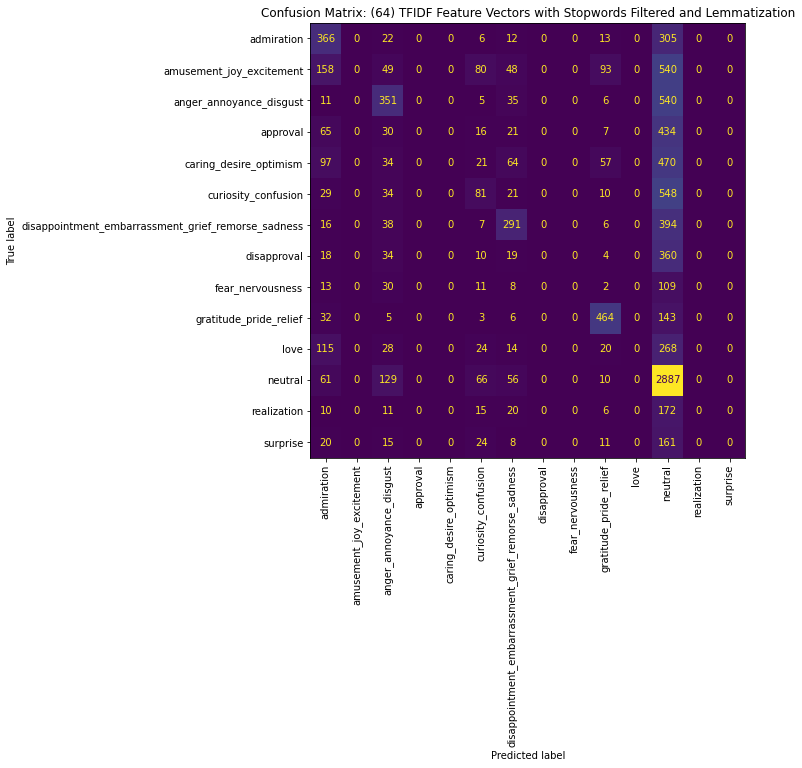

In [141]:
n_hidden = 64

###### BoW ########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow['test'], DATA_FOLDER + 'nn_model_bow_64.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(64) BoW Feature Vectors')


##### TFIDF ##########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf['test'], DATA_FOLDER + 'nn_model_tfidf_64.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(64) TFIDF Feature Vectors')

#### BoW with Stopwords filtered #############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_bow_no_stopws_64.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(64) BoW Feature Vectors with Stopwords Filtered and Lemmatization')

##### TFIDF with stopwords filtered ############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_tfidf_no_stopws_64.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(64) TFIDF Feature Vectors with Stopwords Filtered and Lemmatization')



### Confusion matrix and Classfication Report for Network Size = 256

printing net
Net(
  (hidden): Linear(in_features=29393, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=14, bias=True)
)
The average accuracy score is 0.5074173039712522
Classificaton Report: (256) BoW Feature Vectors
                                                    precision    recall  f1-score   support

                                        admiration       0.52      0.57      0.54       724
                          amusement_joy_excitement       0.60      0.63      0.62       968
                           anger_annoyance_disgust       0.50      0.40      0.44       948
                                          approval       0.25      0.12      0.16       573
                            caring_desire_optimism       0.00      0.00      0.00       743
                               curiosity_confusion       0.37      0.23      0.29       723
disappointment_embarrassment_grief_remorse_sadness       0.52      0.46      0.49       752
                  

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


printing net
Net(
  (hidden): Linear(in_features=29393, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=14, bias=True)
)
The average accuracy score is 0.3367732424214503
Classificaton Report: (256) TFIDF Feature Vectors


/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.09      0.04      0.05       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.00      0.00      0.00       948
                                          approval       0.15      0.13      0.14       573
                            caring_desire_optimism       0.35      0.50      0.41       743
                               curiosity_confusion       0.24      0.24      0.24       723
disappointment_embarrassment_grief_remorse_sadness       0.00      0.00      0.00       752
                                       disapproval       0.11      0.07      0.09       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.14      0.78      0.24       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.00      0.00      0.00       948
                                          approval       0.11      0.37      0.17       573
                            caring_desire_optimism       0.00      0.00      0.00       743
                               curiosity_confusion       0.10      0.57      0.17       723
disappointment_embarrassment_grief_remorse_sadness       0.00      0.00      0.00       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.27      0.74      0.39       724
                          amusement_joy_excitement       0.28      0.74      0.41       968
                           anger_annoyance_disgust       0.00      0.00      0.00       948
                                          approval       0.00      0.00      0.00       573
                            caring_desire_optimism       0.24      0.63      0.35       743
                               curiosity_confusion       0.13      0.38      0.19       723
disappointment_embarrassment_grief_remorse_sadness       0.24      0.64      0.35       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

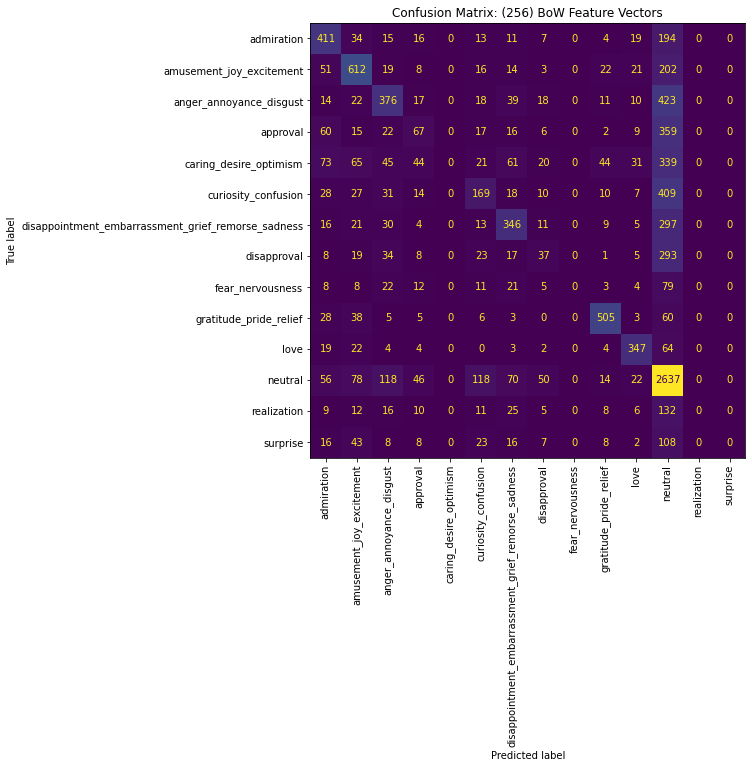

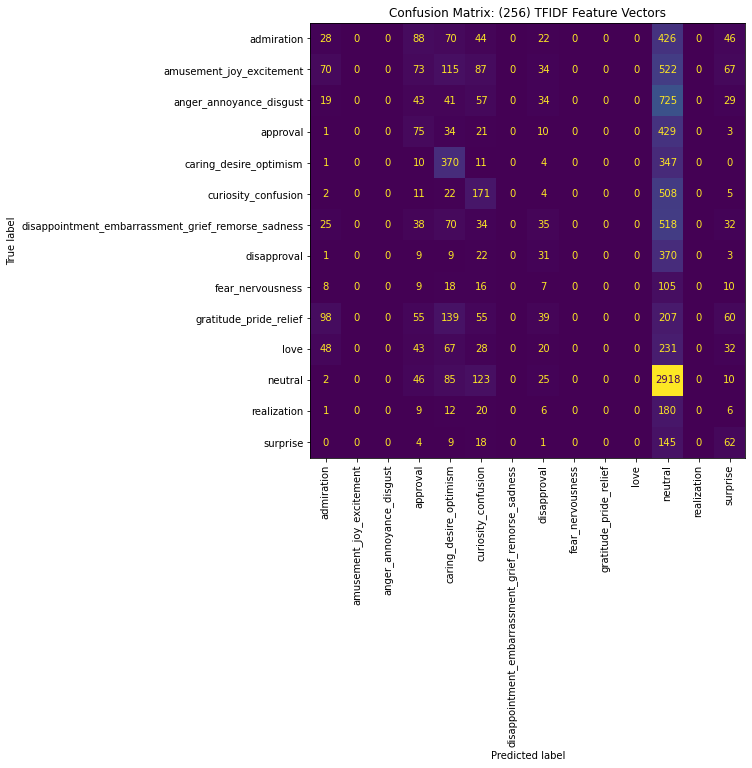

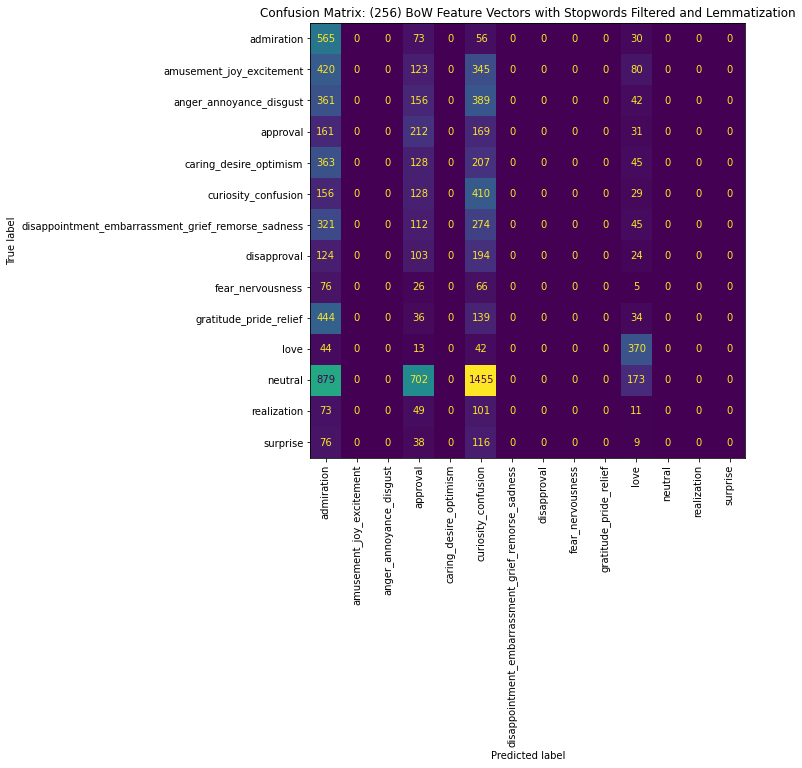

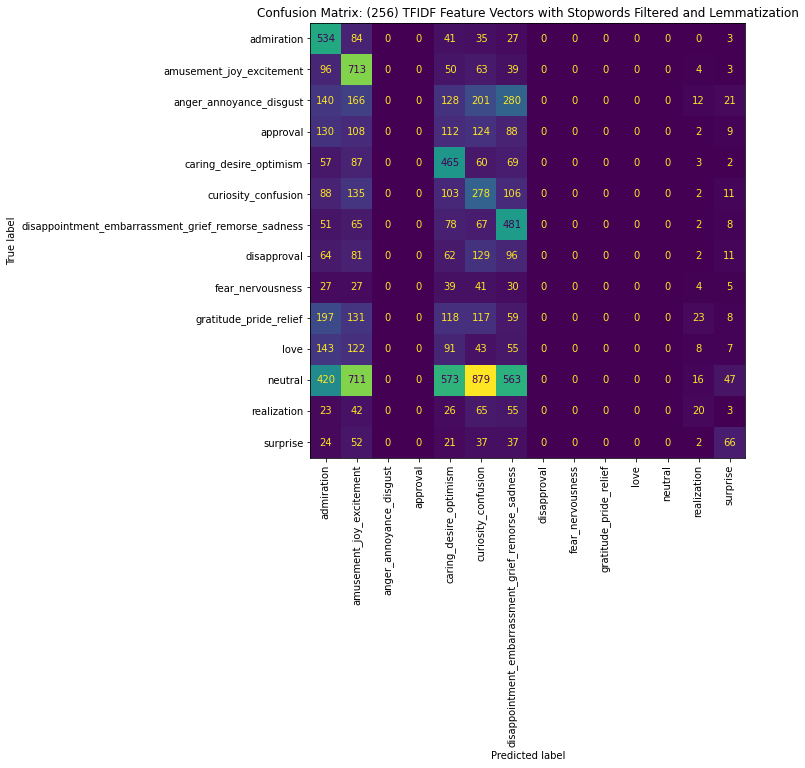

In [142]:
n_hidden = 256

###### BoW ########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow['test'], DATA_FOLDER + 'nn_model_bow_256.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(256) BoW Feature Vectors')


##### TFIDF ##########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf['test'], DATA_FOLDER + 'nn_model_tfidf_256.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(256) TFIDF Feature Vectors')

#### BoW with Stopwords filtered #############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_bow_no_stopws_256.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(256) BoW Feature Vectors with Stopwords Filtered and Lemmatization')

##### TFIDF with stopwords filtered ############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_tfidf_no_stopws_256.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(256) TFIDF Feature Vectors with Stopwords Filtered and Lemmatization')


### Confusion matrix and Classfication Report for Network Size = 1024

printing net
Net(
  (hidden): Linear(in_features=29393, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=14, bias=True)
)
The average accuracy score is 0.46576983322583615
Classificaton Report: (1024) BoW Feature Vectors


/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.42      0.60      0.49       724
                          amusement_joy_excitement       0.58      0.64      0.61       968
                           anger_annoyance_disgust       0.47      0.41      0.44       948
                                          approval       0.24      0.11      0.15       573
                            caring_desire_optimism       0.48      0.50      0.49       743
                               curiosity_confusion       0.33      0.25      0.28       723
disappointment_embarrassment_grief_remorse_sadness       0.50      0.47      0.49       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.04      0.00      0.00       724
                          amusement_joy_excitement       0.26      0.72      0.38       968
                           anger_annoyance_disgust       0.26      0.65      0.37       948
                                          approval       0.14      0.34      0.20       573
                            caring_desire_optimism       0.27      0.64      0.38       743
                               curiosity_confusion       0.00      0.00      0.00       723
disappointment_embarrassment_grief_remorse_sadness       0.00      0.00      0.00       752
                                       disapproval       0.16      0.37      0.22       445
                                  fear_nervousness       0.37      0.55      0.44       173
                            gratitude_pride_relief       0.00      0.00      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.39      0.61      0.48       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.45      0.43      0.44       948
                                          approval       0.00      0.00      0.00       573
                            caring_desire_optimism       0.46      0.46      0.46       743
                               curiosity_confusion       0.00      0.00      0.00       723
disappointment_embarrassment_grief_remorse_sadness       0.47      0.42      0.44       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.48      0.29      0.37       173
                            gratitude_pride_relief       0.74      0.80      0.

/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/HS401/sk02039/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                                        admiration       0.28      0.53      0.37       724
                          amusement_joy_excitement       0.00      0.00      0.00       968
                           anger_annoyance_disgust       0.00      0.00      0.00       948
                                          approval       0.00      0.00      0.00       573
                            caring_desire_optimism       0.38      0.45      0.41       743
                               curiosity_confusion       0.00      0.00      0.00       723
disappointment_embarrassment_grief_remorse_sadness       0.00      0.00      0.00       752
                                       disapproval       0.00      0.00      0.00       445
                                  fear_nervousness       0.00      0.00      0.00       173
                            gratitude_pride_relief       0.00      0.00      0.

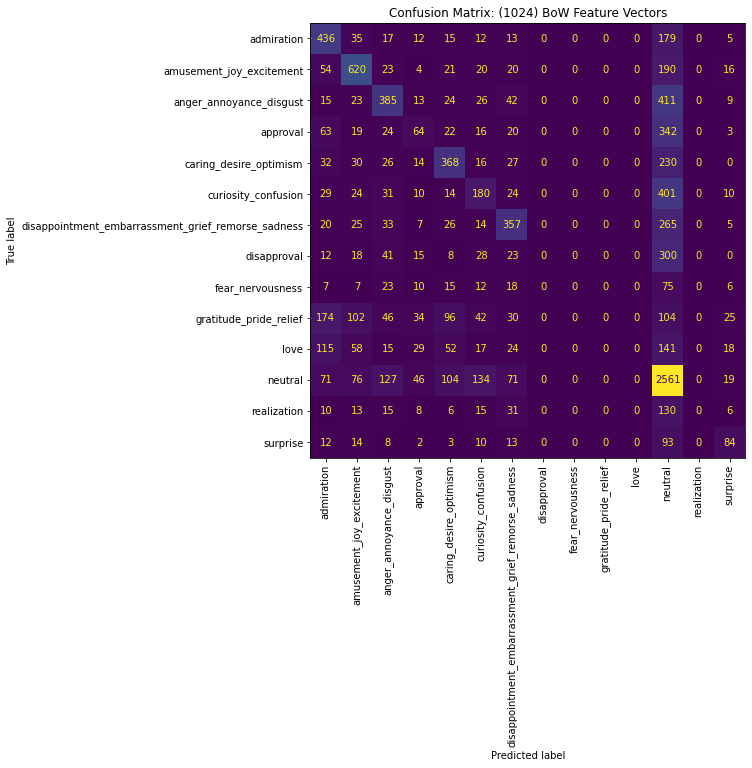

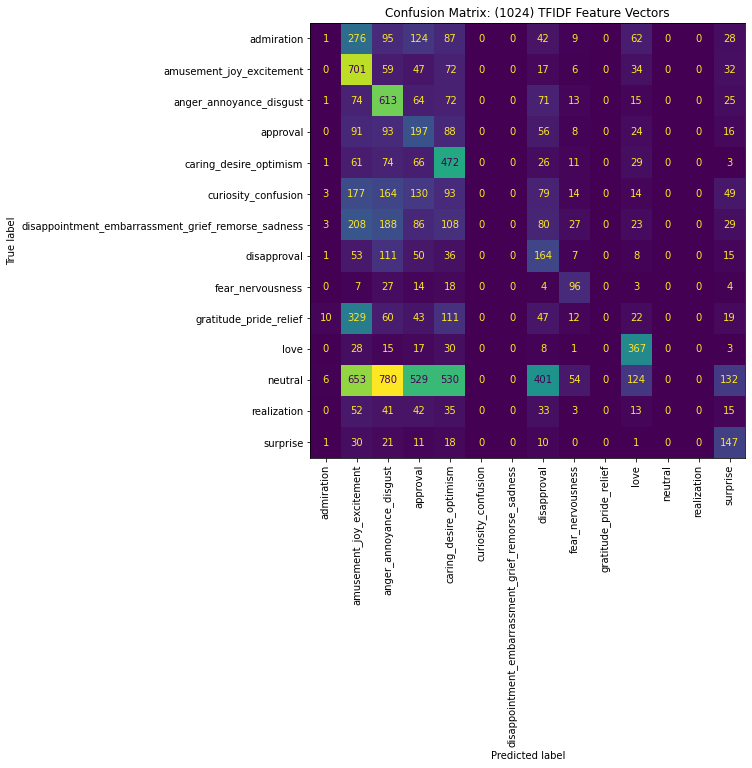

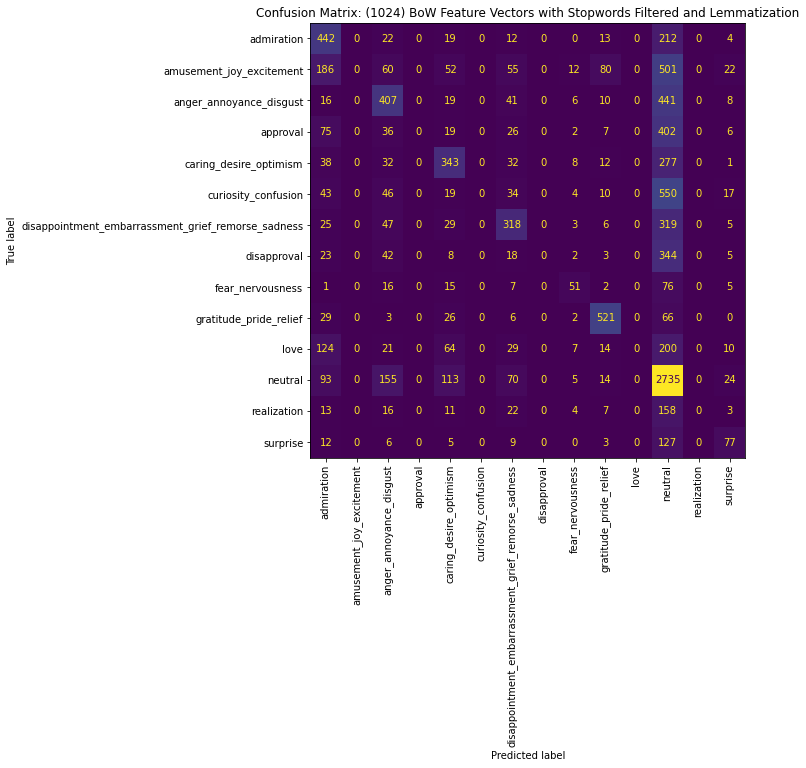

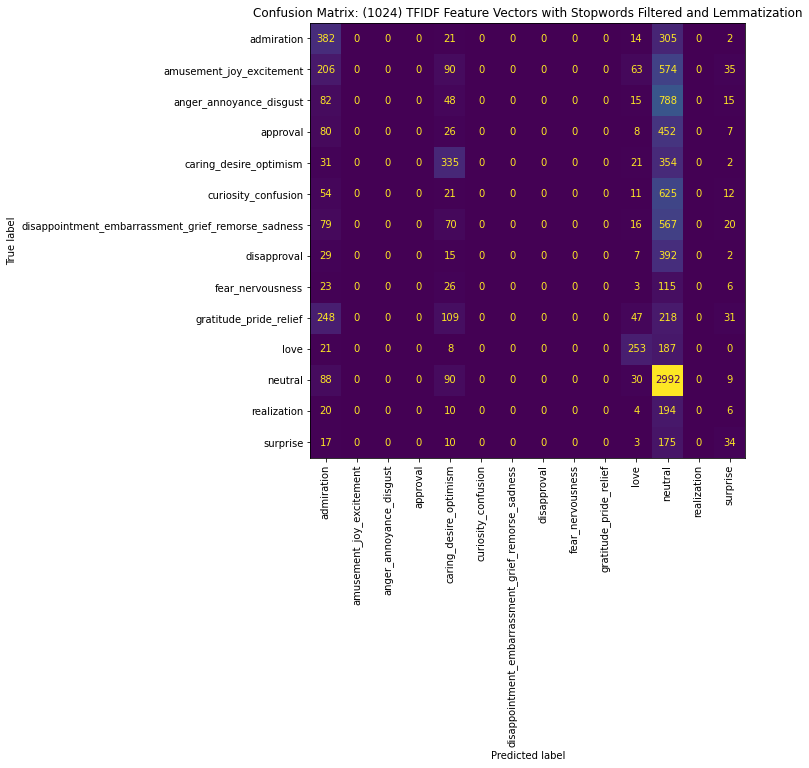

In [143]:
n_hidden = 1024

###### BoW ########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow['test'], DATA_FOLDER + 'nn_model_bow_1024.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(1024) BoW Feature Vectors')


##### TFIDF ##########################
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf['test'], DATA_FOLDER + 'nn_model_tfidf_1024.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(1024) TFIDF Feature Vectors')

#### BoW with Stopwords filtered #############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_bow_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_bow_no_stopws_1024.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(1024) BoW Feature Vectors with Stopwords Filtered and Lemmatization')

##### TFIDF with stopwords filtered ############################
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, y_target, y_pred = EvalNN(model, dataloader_dict_tfidf_no_stopws['test'], 
                               DATA_FOLDER + 'nn_model_tfidf_no_stopws_1024.pkl')
y_target = le.inverse_transform(y_target)
y_pred = le.inverse_transform(y_pred)

GenerateReports(y_true, y_pred, le.classes_, '(1024) TFIDF Feature Vectors with Stopwords Filtered and Lemmatization')


During training, we monitered the change in training loss and the change in validation accuracy. It is expected that the validation accuracy will be increasing with decreasing training loss, but as the model got overfitted, the validation accuracy will decrease over an optimal no of epoch of training. The model parameters are then saved at the point when validation accuracy is maximum. 



As shown in above figures, the validation accuracy peaked at around 40 epochs of training, over which the models became over-fitted. The best accuracy (around 0.45) coming from BoW feature vectors with stop words filtered and lemmatization. It is quite unexpected as shown above, filtering stopwords and lemmatization reduced the total dictionary size, and thus less information is available to traing the classifier. However, given the dictionary sizes of feature vectors are differ by over 40% (19330 Vs 29393) after removing stopwords and lemmatization and keeping stopwords and with no lemmatization, obviously the size of the linear layer for classification should be increased to handle bigger number of feature vectors.

Next, we calculate the testing set accuracy.

In [ ]:
print(f'Test set accuracy for BoW---------------------')
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, *_ = EvalNN(model, dataloader_dict_bow['test'], 'nn_model_bow.pkl')


print(f'Test set accuracy for TFIDF-------------------')
n_feature = feature_vec_dim
model = GetModel(n_feature, n_hidden, n_output)
acc, *_ = EvalNN(model, dataloader_dict_tfidf['test'], 'nn_model_tfidf.pkl')


print(f'Test set accuracy for BoW with stop words filtered and lemmatization-----------------')
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, *_ = EvalNN(model, dataloader_dict_bow_no_stopws['test'], 'nn_model_bow_no_stopws.pkl')


print(f'Test set accuracy for TFIDF with stop words filtered and lemmatization---------------')
n_feature = feature_vec_dim_no_stopws
model = GetModel(n_feature, n_hidden, n_output)
acc, *_ = EvalNN(model, dataloader_dict_tfidf_no_stopws['test'], 'nn_model_tfidf_no_stopws.pkl')



Again, we see that the test set accuracy is best for BoW with stop words filtered and with lemmatization. The best test accuracy is with value around 0.46. As discussed above, it is possible to further improve such accuracy for example by increasing the classification layer size from currently 64 neurons to higher number, or add extra hidden layers. Next we increase the classification layer size to 256 to observe the results.

After increasing the classification layer size from 64 to 256, we observed that the best testing accuracy is 0.476 achieved by the feature vectors with TFIDF, in comparison to 0.459 achieved by TFIDF feature vectors with stopwords filtering and with lemmatization using a 64-neuron classification layer. The improvement is not very prominent when the network size of the classfication layer is increased by 4-fold. Thus, we continue to explore advanced feature extraction approach using prebuilt BERT tokenizer and BERT transformer to see whether there can be improvement. 